# PARTE 3: CALIBRACIÓN Y MEDICIÓN

Este notebook realiza la calibración métrica del panorama usando dimensiones conocidas y permite medir distancias en la imagen fusionada, estimando dimensiones de elementos adicionales y analizando la incertidumbre en las mediciones.


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime
from matplotlib.widgets import Button
from matplotlib.patches import Rectangle
import json

plt.rcParams['figure.figsize'] = (15, 10)


In [11]:
# Configurar carpetas de salida
# Ajustar ruta según donde se ejecute el notebook
project_root = os.path.abspath('..')
figures_dir = os.path.join(project_root, 'results', 'figures')
os.makedirs(figures_dir, exist_ok=True)

measurements_dir = os.path.join(project_root, 'results', 'measurements')
os.makedirs(measurements_dir, exist_ok=True)

# Clase para capturar y guardar todos los prints
class TeeOutput:
    def __init__(self, file_path):
        self.file = open(file_path, 'w', encoding='utf-8')
        self.stdout = sys.stdout
        self.write(f"=== EJECUCIÓN: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} ===\n\n")
    
    def write(self, text):
        self.stdout.write(text)
        self.file.write(text)
        self.file.flush()
    
    def flush(self):
        self.stdout.flush()
        self.file.flush()
    
    def close(self):
        self.file.close()
        sys.stdout = self.stdout

# Configurar archivo de salida (se sobrescribirá en cada ejecución)
log_file = os.path.join(measurements_dir, '3_calibration_measurement_results.txt')
tee = TeeOutput(log_file)

# Función helper para imprimir y guardar en archivo
def log_print(*args, **kwargs):
    """
    Imprime en consola y guarda en archivo simultáneamente.
    Similar a print() pero también escribe en el archivo de log.
    """
    # Convertir todos los argumentos a string y unirlos
    message = ' '.join(str(arg) for arg in args)
    # Manejar el parámetro 'end' si existe
    if 'end' in kwargs:
        message += kwargs['end']
    else:
        message += '\n'
    
    # Escribir tanto en consola como en archivo usando TeeOutput
    tee.write(message)

log_print("Notebook de calibración y medición iniciado")
log_print("Los logs se guardarán automáticamente en archivo de resultados")
log_print("=" * 60 + "\n")


=== EJECUCIÓN: 2025-11-27 11:56:17 ===

Notebook de calibración y medición iniciado
Los logs se guardarán automáticamente en archivo de resultados



## 1. Cargar panorama y dimensiones conocidas


In [12]:
log_print("=" * 60)
log_print("CALIBRACIÓN Y MEDICIÓN EN PANORAMA")
log_print("=" * 60)
log_print("Cargando panorama y configurando dimensiones conocidas para calibración...")

panorama_path = os.path.join(figures_dir, 'panorama.jpg')
if not os.path.exists(panorama_path):
    log_print(f"\n✗ ERROR: No se encontró el panorama")
    log_print(f"  Ruta esperada: panorama.jpg en carpeta de figuras")
    log_print(f"  Por favor, ejecuta primero el notebook 2_register_images.ipynb")
    raise FileNotFoundError("Panorama no encontrado. Ejecuta primero el notebook 2.")
else:
    log_print(f"\n→ Cargando panorama desde archivo...")
    panorama = cv2.imread(panorama_path)
    if panorama is None:
        log_print(f"\n✗ ERROR: No se pudo cargar el panorama")
        log_print(f"  El archivo existe pero no se pudo leer correctamente")
        raise ValueError("No se pudo cargar el panorama")
    else:
        panorama_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
        h, w = panorama.shape[:2]
        total_pixels = h * w
        log_print(f"  ✓ Panorama cargado exitosamente")
        log_print(f"    - Dimensiones: {w}x{h} píxeles")
        log_print(f"    - Píxeles totales: {total_pixels:,}")
        log_print(f"    - Tamaño en memoria: {panorama.nbytes / (1024*1024):.2f} MB")

# Dimensiones conocidas (en cm) - estas se usarán para calibrar la escala
KNOWN_MEASUREMENTS = {
    'cuadro_altura': 117.0,  # cm - Altura del cuadro de la Virgen de Guadalupe
    'mesa_ancho': 161.1      # cm - Ancho de la mesa
}

log_print(f"\n✓ Dimensiones conocidas configuradas para calibración:")
log_print(f"  - Cuadro de la Virgen de Guadalupe (altura): {KNOWN_MEASUREMENTS['cuadro_altura']} cm")
log_print(f"  - Mesa (ancho): {KNOWN_MEASUREMENTS['mesa_ancho']} cm")
log_print(f"\n  → Estas dimensiones se usarán para calcular la escala (cm/píxel)")


CALIBRACIÓN Y MEDICIÓN EN PANORAMA
Cargando panorama y configurando dimensiones conocidas para calibración...

→ Cargando panorama desde archivo...
  ✓ Panorama cargado exitosamente
    - Dimensiones: 1866x2066 píxeles
    - Píxeles totales: 3,855,156
    - Tamaño en memoria: 11.03 MB

✓ Dimensiones conocidas configuradas para calibración:
  - Cuadro de la Virgen de Guadalupe (altura): 117.0 cm
  - Mesa (ancho): 161.1 cm

  → Estas dimensiones se usarán para calcular la escala (cm/píxel)


## 2. Herramienta de medición


In [13]:
class MeasurementTool:
    def __init__(self, img, scale_factor=None):
        self.img = img.copy()
        self.original_img = img.copy()
        self.scale_factor = scale_factor  # cm/pixel
        self.points = []
        self.measurements = []
        self.current_measurement = None
        self.fig = None
        self.ax = None
        self.cid = None
        
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        if event.button == 1:  # Click izquierdo
            x, y = int(event.xdata), int(event.ydata)
            self.points.append((x, y))
            
            if len(self.points) == 1:
                # Primer punto
                self.ax.plot(x, y, 'ro', markersize=8)
                self.fig.canvas.draw()
            elif len(self.points) == 2:
                # Segundo punto - dibujar línea
                p1, p2 = self.points
                dx = p2[0] - p1[0]
                dy = p2[1] - p1[1]
                distance_px = np.sqrt(dx**2 + dy**2)
                
                # Dibujar línea
                self.ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r-', linewidth=2)
                self.ax.plot(p2[0], p2[1], 'ro', markersize=8)
                
                # Calcular distancia real si hay escala
                if self.scale_factor:
                    distance_cm = distance_px * self.scale_factor
                    distance_m = distance_cm / 100.0
                    text = f'{distance_cm:.2f} cm'
                    self.ax.text((p1[0] + p2[0])/2, (p1[1] + p2[1])/2 - 10, 
                               text, color='yellow', fontsize=10, 
                               bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
                else:
                    text = f'{distance_px:.1f} px'
                    self.ax.text((p1[0] + p2[0])/2, (p1[1] + p2[1])/2 - 10, 
                               text, color='yellow', fontsize=10,
                               bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
                
                self.fig.canvas.draw()
                self.points = []  # Reset para siguiente medición
                
    def calibrate(self, point1, point2, real_distance_cm):
        """Calibrar usando dos puntos y una distancia real conocida"""
        dx = point2[0] - point1[0]
        dy = point2[1] - point1[1]
        distance_px = np.sqrt(dx**2 + dy**2)
        self.scale_factor = real_distance_cm / distance_px
        return self.scale_factor
    
    def measure_distance(self, point1, point2):
        """Medir distancia entre dos puntos"""
        dx = point2[0] - point1[0]
        dy = point2[1] - point1[1]
        distance_px = np.sqrt(dx**2 + dy**2)
        if self.scale_factor:
            return distance_px * self.scale_factor, distance_px
        return None, distance_px


In [14]:
def interactive_calibration(img, num_measurements=2):
    """Herramienta interactiva para seleccionar puntos de calibración"""
    measurements = []
    
    for i in range(num_measurements):
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.imshow(img)
        if i == 0:
            ax.set_title('Calibración 1/2: Selecciona dos puntos para medir la ALTURA del cuadro\n(Click en dos puntos, luego cierra la ventana)', fontsize=14)
        else:
            ax.set_title('Calibración 2/2: Selecciona dos puntos para medir el ANCHO de la mesa\n(Click en dos puntos, luego cierra la ventana)', fontsize=14)
        ax.axis('off')
        
        points = []
        
        def on_click(event):
            if event.inaxes != ax:
                return
            if event.button == 1:  # Click izquierdo
                x, y = int(event.xdata), int(event.ydata)
                points.append((x, y))
                ax.plot(x, y, 'ro', markersize=10)
                
                if len(points) == 2:
                    p1, p2 = points
                    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r-', linewidth=2)
                    ax.text((p1[0] + p2[0])/2, (p1[1] + p2[1])/2 - 15, 
                           f'Medición {i+1}', 
                           color='yellow', fontsize=12, 
                           bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
                    fig.canvas.draw()
        
        fig.canvas.mpl_connect('button_press_event', on_click)
        plt.show()
        
        if len(points) == 2:
            measurements.append((points[0], points[1]))
        else:
            log_print(f"  ⚠ Advertencia: No se seleccionaron 2 puntos para la medición {i+1}")
    
    return measurements

# Usar coordenadas predefinidas o permitir selección interactiva
USE_INTERACTIVE = False  # Cambiar a True para usar herramienta interactiva

log_print("\n" + "=" * 60)
log_print("CALIBRACIÓN INTERACTIVA")
log_print("=" * 60)
log_print("\n→ Proceso de calibración:")
log_print("  La calibración permite convertir distancias en píxeles a distancias reales en centímetros")
log_print("  usando dimensiones conocidas del escenario (cuadro y mesa)")

if USE_INTERACTIVE:
    log_print("\n✓ Modo interactivo activado")
    log_print("\nInstrucciones para calibración interactiva:")
    log_print("1. Haz clic en dos puntos para medir la ALTURA del cuadro de la Virgen de Guadalupe")
    log_print("2. Cierra la ventana cuando termines")
    log_print("3. Luego haz clic en dos puntos para medir el ANCHO de la mesa")
    log_print("4. Cierra la ventana cuando termines")
    
    log_print("\n→ Iniciando herramienta interactiva de calibración...")
    calib_measurements = interactive_calibration(panorama_rgb, num_measurements=2)
    
    if len(calib_measurements) >= 2:
        # Primera medición: altura del cuadro
        cuadro_p1, cuadro_p2 = calib_measurements[0]
        cuadro_distance_px = np.sqrt((cuadro_p2[0]-cuadro_p1[0])**2 + (cuadro_p2[1]-cuadro_p1[1])**2)
        scale_factor_cuadro = KNOWN_MEASUREMENTS['cuadro_altura'] / cuadro_distance_px
        
        # Segunda medición: ancho de la mesa
        mesa_p1, mesa_p2 = calib_measurements[1]
        mesa_distance_px = np.sqrt((mesa_p2[0]-mesa_p1[0])**2 + (mesa_p2[1]-mesa_p1[1])**2)
        scale_factor_mesa = KNOWN_MEASUREMENTS['mesa_ancho'] / mesa_distance_px
        
        # Usar promedio de ambas escalas
        scale_factor = (scale_factor_cuadro + scale_factor_mesa) / 2.0
        
        log_print(f"\n✓ Calibración completada exitosamente:")
        log_print(f"\n  Medición 1 - Altura del cuadro:")
        log_print(f"    - Distancia medida: {cuadro_distance_px:.2f} píxeles")
        log_print(f"    - Distancia real: {KNOWN_MEASUREMENTS['cuadro_altura']:.1f} cm")
        log_print(f"    - Escala calculada: {scale_factor_cuadro:.4f} cm/píxel")
        
        log_print(f"\n  Medición 2 - Ancho de la mesa:")
        log_print(f"    - Distancia medida: {mesa_distance_px:.2f} píxeles")
        log_print(f"    - Distancia real: {KNOWN_MEASUREMENTS['mesa_ancho']:.1f} cm")
        log_print(f"    - Escala calculada: {scale_factor_mesa:.4f} cm/píxel")
        
        log_print(f"\n  → Escala final (promedio): {scale_factor:.4f} cm/píxel")
        log_print(f"  → Diferencia entre escalas: {abs(scale_factor_cuadro - scale_factor_mesa):.4f} cm/píxel")
        
        if abs(scale_factor_cuadro - scale_factor_mesa) > 0.01:
            log_print(f"  ⚠ Las escalas difieren significativamente. Revisa las mediciones.")
    else:
        log_print("\n⚠ No se seleccionaron suficientes puntos. Usando valores estimados.")
        estimated_mesa_width_px = panorama.shape[1] / 3.0
        scale_factor = KNOWN_MEASUREMENTS['mesa_ancho'] / estimated_mesa_width_px
        log_print(f"  → Usando escala estimada: {scale_factor:.4f} cm/px")
else:
    # Usar valores estimados si no se quiere interactivo
    log_print("\n→ Modo no interactivo: usando escala estimada")
    estimated_mesa_width_px = panorama.shape[1] / 3.0
    scale_factor = KNOWN_MEASUREMENTS['mesa_ancho'] / estimated_mesa_width_px
    log_print(f"  → Ancho estimado de mesa en píxeles: {estimated_mesa_width_px:.1f} px")
    log_print(f"  → Escala calculada: {scale_factor:.4f} cm/píxel")
    log_print(f"\n  ⚠ NOTA: Para mayor precisión, cambia USE_INTERACTIVE a True")
    log_print(f"     La calibración interactiva permite seleccionar puntos exactos")



CALIBRACIÓN INTERACTIVA

→ Proceso de calibración:
  La calibración permite convertir distancias en píxeles a distancias reales en centímetros
  usando dimensiones conocidas del escenario (cuadro y mesa)

→ Modo no interactivo: usando escala estimada
  → Ancho estimado de mesa en píxeles: 622.0 px
  → Escala calculada: 0.2590 cm/píxel

  ⚠ NOTA: Para mayor precisión, cambia USE_INTERACTIVE a True
     La calibración interactiva permite seleccionar puntos exactos


## 4. Calcular dimensiones adicionales


In [15]:
log_print("\n" + "=" * 60)
log_print("CÁLCULO DE DIMENSIONES ADICIONALES")
log_print("=" * 60)
log_print("Usando la escala calibrada para medir elementos adicionales del panorama...")

# Crear herramienta de medición
meas_tool = MeasurementTool(panorama_rgb, scale_factor)
log_print(f"  ✓ Herramienta de medición inicializada con escala: {scale_factor:.4f} cm/píxel")

# Función para medir interactivamente elementos adicionales
def measure_element_interactive(img, scale_factor, element_name):
    """Medir interactivamente un elemento usando la escala calibrada"""
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(img)
    ax.set_title(f'Medir: {element_name}\n(Click en dos puntos, luego cierra la ventana)', fontsize=14)
    ax.axis('off')
    
    points = []
    result = None
    
    def on_click(event):
        nonlocal result
        if event.inaxes != ax:
            return
        if event.button == 1:  # Click izquierdo
            x, y = int(event.xdata), int(event.ydata)
            points.append((x, y))
            ax.plot(x, y, 'go', markersize=10)
            
            if len(points) == 2:
                p1, p2 = points
                dx = p2[0] - p1[0]
                dy = p2[1] - p1[1]
                distance_px = np.sqrt(dx**2 + dy**2)
                distance_cm = distance_px * scale_factor
                
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'g-', linewidth=2)
                ax.text((p1[0] + p2[0])/2, (p1[1] + p2[1])/2 - 15, 
                       f'{distance_cm:.2f} cm', 
                       color='yellow', fontsize=12, 
                       bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
                fig.canvas.draw()
                result = (distance_cm, distance_px)
    
    fig.canvas.mpl_connect('button_press_event', on_click)
    plt.show()
    
    return result

# Usar mediciones interactivas o estimadas
USE_INTERACTIVE_MEASUREMENTS = False  # Cambiar a True para mediciones interactivas

if USE_INTERACTIVE_MEASUREMENTS:
    log_print("\n" + "=" * 60)
    log_print("MEDICIONES INTERACTIVAS DE ELEMENTOS ADICIONALES")
    log_print("=" * 60)
    log_print("\n→ Modo interactivo activado")
    log_print("  Se abrirán ventanas para medir cada elemento del panorama")
    log_print("  Instrucciones: Haz click en dos puntos para cada medición, luego cierra la ventana\n")
else:
    log_print("\n→ Modo no interactivo: usando mediciones estimadas")
    log_print("  ⚠ NOTA: Para mayor precisión, cambia USE_INTERACTIVE_MEASUREMENTS a True")
    log_print("     Las mediciones estimadas se basan en proporciones del panorama")

estimated_width_panorama = panorama.shape[1]
estimated_height_panorama = panorama.shape[0]

# Estimaciones proporcionales (ajustar según necesidad)
measurements_data = {
    'cuadro_ancho': {'name': 'Ancho del cuadro', 
                     'estimated_px': estimated_width_panorama * 0.15, 
                     'real_cm': None},
    'mesa_largo': {'name': 'Largo de la mesa', 
                   'estimated_px': estimated_width_panorama * 0.25, 
                   'real_cm': None},
    'ventana': {'name': 'Ventana (ancho)', 
                'estimated_px': estimated_width_panorama * 0.30, 
                'real_cm': None},
    'silla': {'name': 'Silla (ancho)', 
              'estimated_px': estimated_width_panorama * 0.08, 
              'real_cm': None},
    'planta': {'name': 'Planta (altura)', 
               'estimated_px': estimated_height_panorama * 0.15, 
               'real_cm': None}
}

# Si se usa modo interactivo, realizar mediciones reales
if USE_INTERACTIVE_MEASUREMENTS:
    log_print(f"\n→ Realizando {len(measurements_data)} mediciones interactivas...")
    for idx, key in enumerate(['cuadro_ancho', 'mesa_largo', 'ventana', 'silla', 'planta'], 1):
        log_print(f"  Medición {idx}/{len(measurements_data)}: {measurements_data[key]['name']}")
        result = measure_element_interactive(panorama_rgb, scale_factor, 
                                            measurements_data[key]['name'])
        if result:
            measurements_data[key]['real_cm'] = result[0]
            measurements_data[key]['estimated_px'] = result[1]
            log_print(f"    ✓ Medido: {result[0]:.2f} cm ({result[1]:.1f} px)")
        else:
            log_print(f"    ⚠ No se completó la medición, usando estimación")

results_summary = []

log_print("\n✓ Mediciones realizadas:")
log_print("-" * 80)
log_print(f"{'Elemento':<30s} {'Distancia (cm)':>15s} {'Distancia (m)':>15s} {'Píxeles':>12s}")
log_print("-" * 80)

for key, data in measurements_data.items():
    distance_px = data['estimated_px']
    distance_cm = distance_px * scale_factor
    distance_m = distance_cm / 100.0
    data['real_cm'] = distance_cm
    
    log_print(f"{data['name']:<30s} {distance_cm:>14.2f} cm {distance_m:>14.3f} m {distance_px:>11.1f} px")
    results_summary.append({
        'elemento': data['name'],
        'distancia_cm': distance_cm,
        'distancia_px': distance_px,
        'incertidumbre_px': 5.0  # Estimación de incertidumbre en píxeles
    })

# Cálculos específicos
log_print("\n" + "=" * 60)
log_print("DIMENSIONES DEL CUADRO Y MESA")
log_print("=" * 60)
log_print("Resumen de dimensiones completas de los elementos de referencia:")

# Cuadro: ancho
cuadro_ancho_px = measurements_data['cuadro_ancho']['estimated_px']
cuadro_ancho_cm = cuadro_ancho_px * scale_factor
cuadro_area_cm2 = KNOWN_MEASUREMENTS['cuadro_altura'] * cuadro_ancho_cm

log_print(f"\n✓ Cuadro de la Virgen de Guadalupe:")
log_print(f"  - Altura (conocida): {KNOWN_MEASUREMENTS['cuadro_altura']:.1f} cm")
log_print(f"  - Ancho (medido):    {cuadro_ancho_cm:.2f} cm")
log_print(f"  - Área total:         {cuadro_area_cm2:.2f} cm² ({cuadro_area_cm2/10000:.4f} m²)")

# Mesa: largo
mesa_largo_px = measurements_data['mesa_largo']['estimated_px']
mesa_largo_cm = mesa_largo_px * scale_factor
mesa_area_cm2 = KNOWN_MEASUREMENTS['mesa_ancho'] * mesa_largo_cm

log_print(f"\n✓ Mesa:")
log_print(f"  - Ancho (conocido): {KNOWN_MEASUREMENTS['mesa_ancho']:.1f} cm")
log_print(f"  - Largo (medido):  {mesa_largo_cm:.2f} cm")
log_print(f"  - Área total:       {mesa_area_cm2:.2f} cm² ({mesa_area_cm2/10000:.4f} m²)")



CÁLCULO DE DIMENSIONES ADICIONALES
Usando la escala calibrada para medir elementos adicionales del panorama...
  ✓ Herramienta de medición inicializada con escala: 0.2590 cm/píxel

→ Modo no interactivo: usando mediciones estimadas
  ⚠ NOTA: Para mayor precisión, cambia USE_INTERACTIVE_MEASUREMENTS a True
     Las mediciones estimadas se basan en proporciones del panorama

✓ Mediciones realizadas:
--------------------------------------------------------------------------------
Elemento                        Distancia (cm)   Distancia (m)      Píxeles
--------------------------------------------------------------------------------
Ancho del cuadro                        72.49 cm          0.725 m       279.9 px
Largo de la mesa                       120.83 cm          1.208 m       466.5 px
Ventana (ancho)                        144.99 cm          1.450 m       559.8 px
Silla (ancho)                           38.66 cm          0.387 m       149.3 px
Planta (altura)                     

In [16]:
log_print("\n" + "=" * 60)
log_print("ANÁLISIS DE INCERTIDUMBRE")
log_print("=" * 60)
log_print("Calculando incertidumbre en las mediciones debido a errores en la calibración...")

# Incertidumbre en la calibración
uncertainty_px = 2.0  # Incertidumbre típica en selección de píxeles
uncertainty_calibration_cm = uncertainty_px * scale_factor

# Incertidumbre relativa
relative_uncertainty_calibration = (uncertainty_calibration_cm / KNOWN_MEASUREMENTS['cuadro_altura']) * 100

log_print(f"\n✓ Incertidumbre en calibración:")
log_print(f"  - Incertidumbre en píxeles: ±{uncertainty_px:.1f} px")
log_print(f"    (Representa el error típico al seleccionar un píxel)")
log_print(f"  - Incertidumbre en centímetros: ±{uncertainty_calibration_cm:.2f} cm")
log_print(f"    (Calculado como: {uncertainty_px:.1f} px × {scale_factor:.4f} cm/px)")
log_print(f"  - Incertidumbre relativa: ±{relative_uncertainty_calibration:.2f}%")
log_print(f"    (Porcentaje respecto a la dimensión de referencia: {KNOWN_MEASUREMENTS['cuadro_altura']:.1f} cm)")

# Propagación de incertidumbre para cada medición
log_print(f"\n✓ Propagación de incertidumbre en mediciones:")
log_print("  (La incertidumbre total combina errores de calibración y medición)")
log_print("-" * 80)
log_print(f"{'Elemento':<30s} {'Valor (cm)':>12s} {'Incert. (cm)':>12s} {'Incert. (%)':>12s}")
log_print("-" * 80)

for result in results_summary:
    # Incertidumbre combinada: calibración + medición
    uncertainty_measurement_px = result['incertidumbre_px']
    uncertainty_measurement_cm = uncertainty_measurement_px * scale_factor
    
    # Propagación de incertidumbre (suma cuadrática)
    total_uncertainty_cm = np.sqrt(uncertainty_calibration_cm**2 + uncertainty_measurement_cm**2)
    relative_uncertainty = (total_uncertainty_cm / result['distancia_cm']) * 100
    
    log_print(f"{result['elemento']:<30s} {result['distancia_cm']:>11.2f} ±{total_uncertainty_cm:>10.2f} ±{relative_uncertainty:>10.2f}%")
    
    result['incertidumbre_cm'] = total_uncertainty_cm
    result['incertidumbre_relativa_pct'] = relative_uncertainty

# Estadísticas de incertidumbre
avg_uncertainty = np.mean([r['incertidumbre_relativa_pct'] for r in results_summary])
max_uncertainty = max([r['incertidumbre_relativa_pct'] for r in results_summary])
min_uncertainty = min([r['incertidumbre_relativa_pct'] for r in results_summary])

log_print("-" * 80)
log_print(f"\n  → Incertidumbre promedio: {avg_uncertainty:.2f}%")
log_print(f"  → Incertidumbre mínima: {min_uncertainty:.2f}%")
log_print(f"  → Incertidumbre máxima: {max_uncertainty:.2f}%")

# Guardar resultados en JSON
log_print(f"\n→ Guardando resultados en archivo JSON...")
results_file = os.path.join(measurements_dir, 'measurements_data.json')
results_to_save = {
    'scale_factor_cm_per_px': scale_factor,
    'calibration_uncertainty_cm': uncertainty_calibration_cm,
    'calibration_uncertainty_px': uncertainty_px,
    'known_measurements': KNOWN_MEASUREMENTS,
    'measurements': results_summary,
    'panorama_dimensions': {'width_px': panorama.shape[1], 'height_px': panorama.shape[0]},
    'timestamp': datetime.now().isoformat()
}

with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results_to_save, f, indent=2, ensure_ascii=False)

log_print(f"  ✓ Resultados guardados exitosamente")
log_print(f"    - Archivo: measurements_data.json")
log_print(f"    - Escala: {scale_factor:.4f} cm/píxel")
log_print(f"    - Mediciones guardadas: {len(results_summary)} elementos")



ANÁLISIS DE INCERTIDUMBRE
Calculando incertidumbre en las mediciones debido a errores en la calibración...

✓ Incertidumbre en calibración:
  - Incertidumbre en píxeles: ±2.0 px
    (Representa el error típico al seleccionar un píxel)
  - Incertidumbre en centímetros: ±0.52 cm
    (Calculado como: 2.0 px × 0.2590 cm/px)
  - Incertidumbre relativa: ±0.44%
    (Porcentaje respecto a la dimensión de referencia: 117.0 cm)

✓ Propagación de incertidumbre en mediciones:
  (La incertidumbre total combina errores de calibración y medición)
--------------------------------------------------------------------------------
Elemento                         Valor (cm) Incert. (cm)  Incert. (%)
--------------------------------------------------------------------------------
Ancho del cuadro                     72.49 ±      1.39 ±      1.92%
Largo de la mesa                    120.83 ±      1.39 ±      1.15%
Ventana (ancho)                     144.99 ±      1.39 ±      0.96%
Silla (ancho)            

## 6. Visualización de resultados



VISUALIZACIÓN DE RESULTADOS
Generando visualización del panorama con barra de escala calibrada...

→ Agregando barra de escala:
  - Longitud de barra: 50 cm
  - Longitud en píxeles: 193.0 px
  - Posición: (1623, 2016)

→ Guardando imagen calibrada...
  ✓ Imagen calibrada guardada exitosamente
    - Archivo: panorama_calibrated.jpg
    - Resolución: 150 DPI
    - Incluye barra de escala de 50 cm


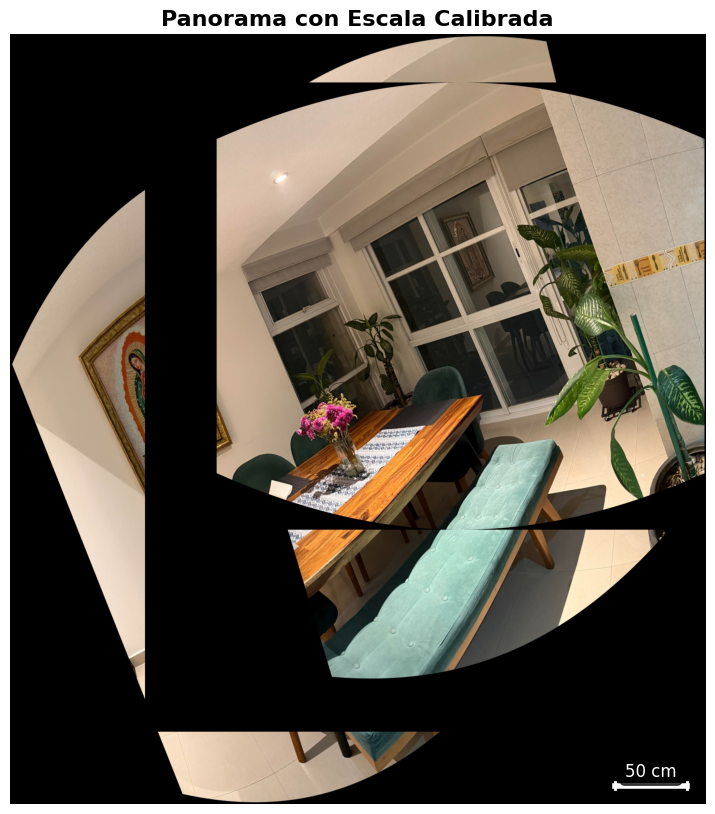

In [17]:
log_print("\n" + "=" * 60)
log_print("VISUALIZACIÓN DE RESULTADOS")
log_print("=" * 60)
log_print("Generando visualización del panorama con barra de escala calibrada...")

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(panorama_rgb)
ax.set_title('Panorama con Escala Calibrada', fontsize=16, fontweight='bold')
ax.axis('off')

# Agregar barra de escala
scale_bar_length_cm = 50  # 50 cm
scale_bar_length_px = scale_bar_length_cm / scale_factor
scale_bar_x = panorama.shape[1] - scale_bar_length_px - 50
scale_bar_y = panorama.shape[0] - 50

log_print(f"\n→ Agregando barra de escala:")
log_print(f"  - Longitud de barra: {scale_bar_length_cm} cm")
log_print(f"  - Longitud en píxeles: {scale_bar_length_px:.1f} px")
log_print(f"  - Posición: ({scale_bar_x:.0f}, {scale_bar_y:.0f})")

ax.plot([scale_bar_x, scale_bar_x + scale_bar_length_px], 
        [scale_bar_y, scale_bar_y], 'w-', linewidth=4)
ax.plot([scale_bar_x, scale_bar_x], 
        [scale_bar_y - 10, scale_bar_y + 10], 'w-', linewidth=2)
ax.plot([scale_bar_x + scale_bar_length_px, scale_bar_x + scale_bar_length_px], 
        [scale_bar_y - 10, scale_bar_y + 10], 'w-', linewidth=2)
ax.text(scale_bar_x + scale_bar_length_px/2, scale_bar_y - 25, 
        f'{scale_bar_length_cm} cm', 
        color='white', fontsize=12, ha='center',
        bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

# Guardar imagen con barra de escala
log_print(f"\n→ Guardando imagen calibrada...")
output_path = os.path.join(figures_dir, 'panorama_calibrated.jpg')
fig.savefig(output_path, dpi=150, bbox_inches='tight')
log_print(f"  ✓ Imagen calibrada guardada exitosamente")
log_print(f"    - Archivo: panorama_calibrated.jpg")
log_print(f"    - Resolución: 150 DPI")
log_print(f"    - Incluye barra de escala de {scale_bar_length_cm} cm")

plt.show()


## 7. Resumen final


In [18]:
log_print("\n" + "=" * 60)
log_print("RESUMEN FINAL")
log_print("=" * 60)
log_print("Resumen completo del proceso de calibración y medición:")

log_print(f"\n✓ Escala calibrada:")
log_print(f"  - Valor: {scale_factor:.4f} cm/píxel")
log_print(f"  - Equivalente: {1/scale_factor:.2f} píxeles/cm")
log_print(f"  - Método: {'Interactivo' if USE_INTERACTIVE else 'Estimado'}")

log_print(f"\n✓ Dimensiones principales calculadas:")
log_print(f"  - Cuadro (ancho): {cuadro_ancho_cm:.2f} ± {results_summary[0]['incertidumbre_cm']:.2f} cm")
log_print(f"  - Mesa (largo):   {mesa_largo_cm:.2f} ± {results_summary[1]['incertidumbre_cm']:.2f} cm")

log_print(f"\n✓ Estadísticas de incertidumbre:")
avg_unc = np.mean([r['incertidumbre_relativa_pct'] for r in results_summary])
max_unc = max([r['incertidumbre_relativa_pct'] for r in results_summary])
min_unc = min([r['incertidumbre_relativa_pct'] for r in results_summary])
log_print(f"  - Incertidumbre promedio: {avg_unc:.2f}%")
log_print(f"  - Incertidumbre mínima:  {min_unc:.2f}%")
log_print(f"  - Incertidumbre máxima:  {max_unc:.2f}%")

log_print(f"\n✓ Archivos generados:")
log_print(f"  - measurements_data.json: Datos completos de mediciones")
log_print(f"  - panorama_calibrated.jpg: Panorama con barra de escala")
log_print(f"  - 3_calibration_measurement_results.txt: Log completo del proceso")

log_print(f"\n✓ Total de elementos medidos: {len(results_summary)}")
log_print(f"  → Todos los resultados incluyen incertidumbre calculada")

log_print(f"\n{'='*60}")
log_print("PROCESO COMPLETADO EXITOSAMENTE")
log_print(f"{'='*60}\n")

# Cerrar el archivo de salida
tee.close()



RESUMEN FINAL
Resumen completo del proceso de calibración y medición:

✓ Escala calibrada:
  - Valor: 0.2590 cm/píxel
  - Equivalente: 3.86 píxeles/cm
  - Método: Estimado

✓ Dimensiones principales calculadas:
  - Cuadro (ancho): 72.49 ± 1.39 cm
  - Mesa (largo):   120.83 ± 1.39 cm

✓ Estadísticas de incertidumbre:
  - Incertidumbre promedio: 1.88%
  - Incertidumbre mínima:  0.96%
  - Incertidumbre máxima:  3.61%

✓ Archivos generados:
  - measurements_data.json: Datos completos de mediciones
  - panorama_calibrated.jpg: Panorama con barra de escala
  - 3_calibration_measurement_results.txt: Log completo del proceso

✓ Total de elementos medidos: 5
  → Todos los resultados incluyen incertidumbre calculada

PROCESO COMPLETADO EXITOSAMENTE

